# Welcome to the LatentDiffEq.jl tutorial!

In this tutorial we will learn how to define a GOKU-net model and train it on pendulum videos.

Let's first activate the tutorial project and install all the required packages in their right versions:

In [2]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating environment at `~/.julia/dev/LatentDiffEq/examples/tutorial/Project.toml`


The previous step can take a while (~ 10 min) if this is the first time you run it. While waiting, you can watch the JuliaCon 2021 talk which briefly explains the motiviation and main concepts behind the LatentDiffEq.jl package.

[![Alt text](https://i.ytimg.com/vi/jhIgs4swrMA/hq720.jpg?sqp=-oaymwEXCNAFEJQDSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLDirBL7fLKzeUk4v7OM9LpPUR9CwQ)](https://www.youtube.com/watch?v=jhIgs4swrMA)

In [ ]:
using LatentDiffEq
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
using Random
using Statistics
using MLDataUtils
using Flux.Data: DataLoader
using Flux
using OrdinaryDiffEq
using DiffEqSensitivity
using Images
using Plots

## Latent differential equation definition

In [ ]:
struct Pendulum{P,S,T,K}

    prob::P
    solver::S
    sensealg::T
    kwargs::K

    function Pendulum(; kwargs...)
        # Parameters and initial conditions only
        # used to initialize the ODE problem
        u₀ = Float32[1.0, 1.0]
        p = Float32[1.]
        tspan = (0.f0, 1.f0)

        # Define differential equations
        function f!(du, u, p, t)
                x, y = u
                G = 10.0f0
                L = p[1]
                
                du[1] = y
                du[2] =  -G/L*sin(x)
        end

        # Build ODE Problem
        prob = ODEProblem(f!, u₀, tspan, p)

        # Chose a solver and sensitivity algorithm
        solver = Tsit5()
        sensalg = BacksolveAdjoint(autojacvec=ReverseDiffVJP(true))

        P = typeof(prob)
        S = typeof(solver)
        T = typeof(sensalg)
        K = typeof(kwargs)
        new{P,S,T,K}(prob, solver, sensalg, kwargs)
    end
    
end

For more information about defining differential equations you can refer to the [DifferentialEquations.jl tutorials](https://diffeq.sciml.ai/dev/tutorials/ode_example/) and regarding the different sensitivity algorithms choices, you can address the the corresponding [DiffEqFlux.jl documentation](https://diffeqflux.sciml.ai/dev/ControllingAdjoints/).

## Model type, latent differential equations and hyperparameters

In [ ]:
## Global model
model_type = GOKU()

## Latent Differential Equations
diffeq = Pendulum()

## Training params
η = 1e-3                        # learning rate
decay = 0.001f0                 # decay applied to weights during optimisation
batch_size = 64                 # minibatch size
seq_len = 50                    # sequence length for training samples
epochs = 1500                   # number of epochs for training
seed = 3                        # random seed
dt = 0.05                       # timestep for ode solve
variational = true              # variational or deterministic training

## Annealing schedule
start_β = 0f0                   # start value
end_β = 1f0                     # end value
n_cycle = 4                     # number of annealing cycles
ratio = 0.9                     # proportion used to increase β (and 1-ratio used to fix β)

## Visualization
vis_len = 60                    # number of test frames to visualize after each epoch  

## Data creation: pixel pendulums with different lengths

In [ ]:
# script for generating pendulum videos
include("create_data.jl")

In [ ]:
latent_data, z₀s, params_data, high_dim_data = generate_dataset(diffeq = diffeq);

Let's see the dimensions of `high_dim_data`, which contains the pendulum videos.

In [ ]:
@show size(high_dim_data) # different samples
@show size(high_dim_data[1]) # time steps
@show size(high_dim_data[1][1]); # frames

In order to have a better sense of the data that we are working with, let's see some animations of different samples:

In [ ]:
@gif for i ∈ 1:length(high_dim_data[1])
    plts = plot.([Gray.(high_dim_data[j][i]) for j in 1:9])
    plot(plts..., size = (200,200), axis=nothing)
end

Although the true pendulum length (sampled from a uniform distribution between 1 and 2) varies among different samples, the visual length in the images is always the same. The data is created in this way so that the parameters of the differential equations cannot be simply inferred from geometry, but rather are encoded in the dynamics.

## Data wrangling 

In [ ]:
Random.seed!(seed) # fix random seed for reproducivility

In [ ]:
# Stack time for each sample
high_dim_data = Flux.stack.(high_dim_data, 3)

# Stack all samples
high_dim_data = Flux.stack(high_dim_data, 4)
h, w, full_seq_len, observations = size(high_dim_data) # 28x28x400x450
latent_data = Flux.stack(latent_data, 3)
params_data = Flux.stack(params_data, 3);

In [ ]:
# Vectorize frames
high_dim_data = reshape(high_dim_data, :, full_seq_len, observations) # input_dim, time_size, samples
high_dim_data = Float32.(high_dim_data)

train_set, val_set = Array.(splitobs(high_dim_data, 0.9))
train_set_latent, val_set_latent = Array.(splitobs(latent_data, 0.9))
train_set_params, val_set_params = Array.(splitobs(params_data, 0.9));

In [ ]:
loader_train = DataLoader((train_set, train_set_latent), batchsize=batch_size, shuffle=true, partial=false)
val_set_time_unstacked = Flux.unstack(val_set, 2)
input_dim = size(train_set, 1);

## Layers definitions

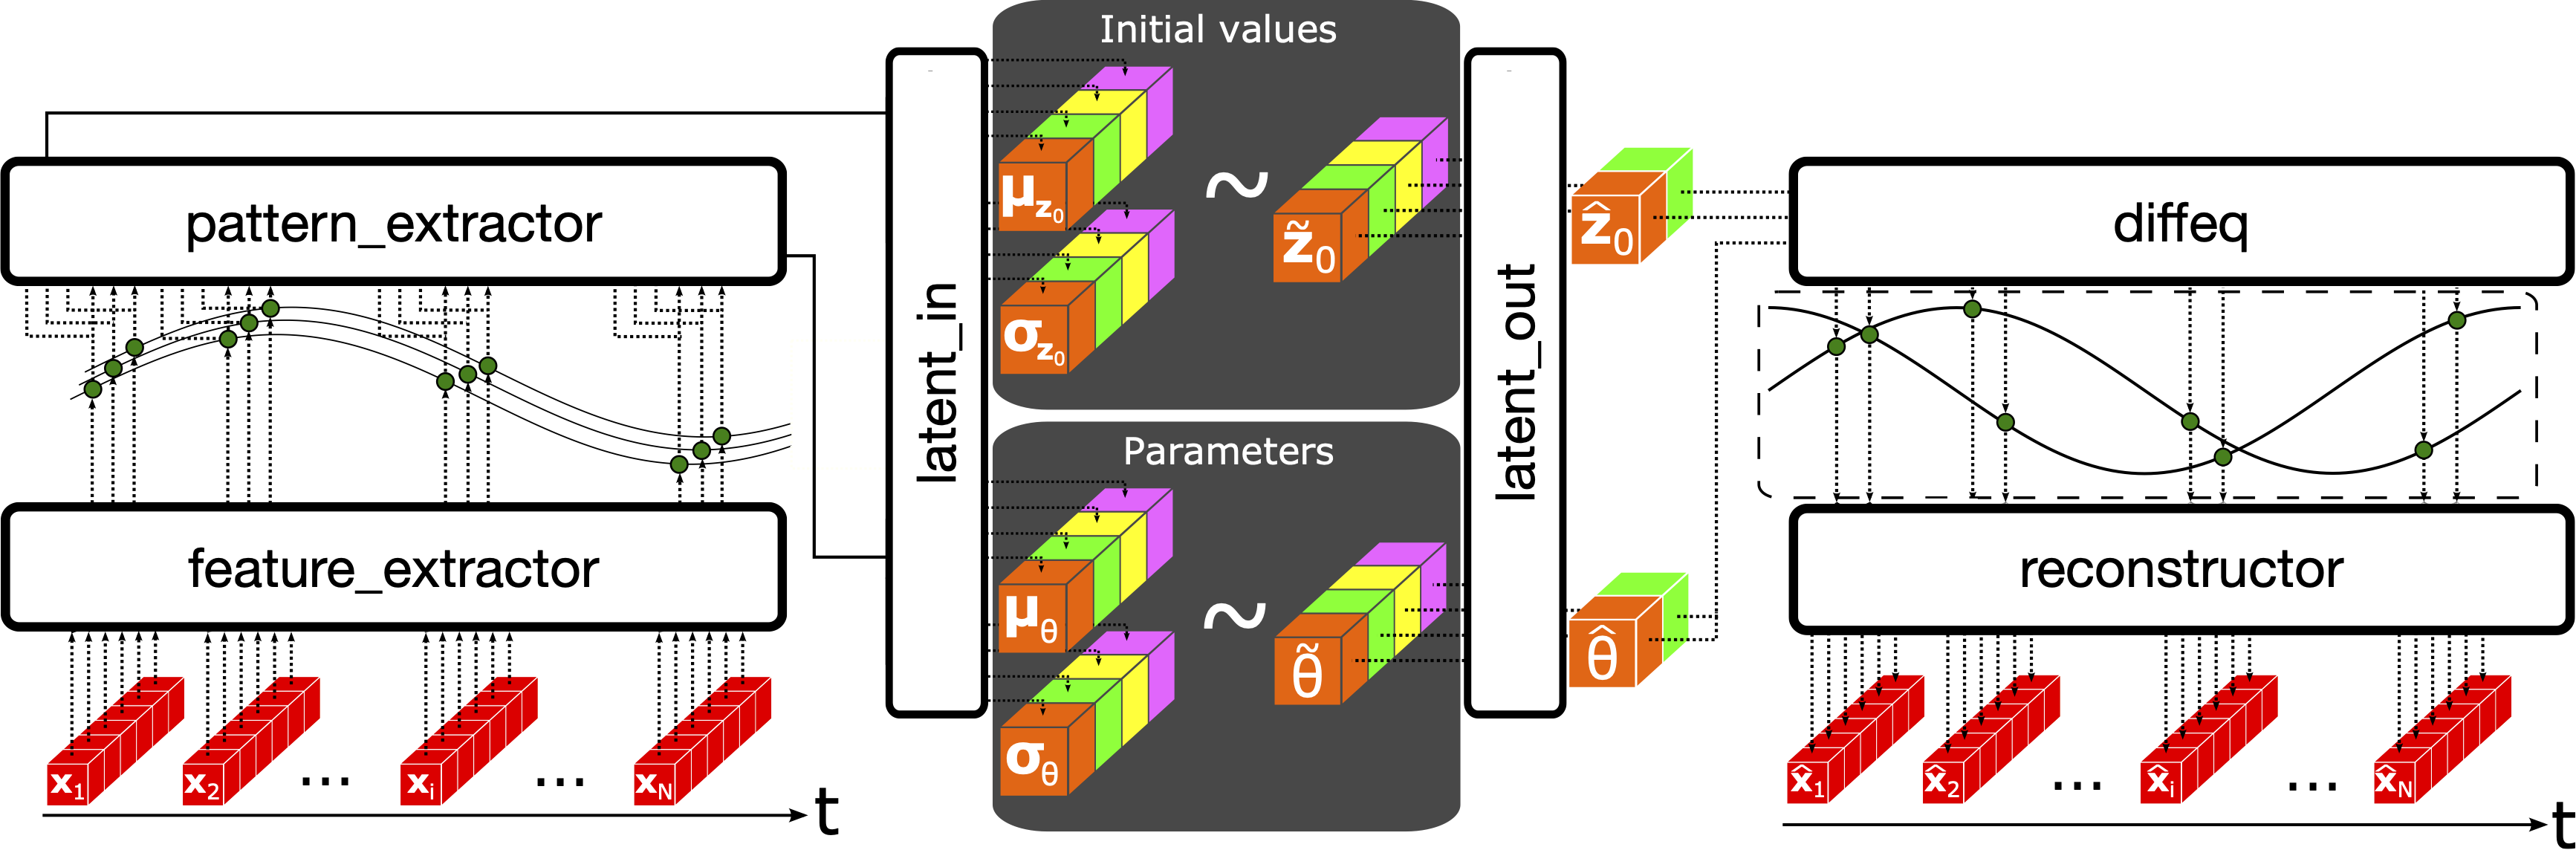

If you wish to use exactly the same architecture as in the original [GOKU-net paper](https://dl.acm.org/doi/abs/10.1145/3450439.3451866) you can conveniently use the `default_layers` function:

`encoder_layers, decoder_layers = default_layers(model_type, input_dim, diffeq)`

However, let's define each layer manually (using [Flux.jl](https://fluxml.ai/Flux.jl/stable/)) so that you can easily modify them.

### Dimensions and hyperparameters

In [ ]:
# Let's set the same dimensions and hyperparameters as in the original GOKU-net implementation
hidden_dim_resnet = 200
rnn_input_dim = 32
rnn_output_dim = 16
latent_dim = 16
latent_to_diffeq_dim = 200
θ_activation = softplus
output_activation = σ
init = Flux.kaiming_uniform(gain = 1/sqrt(3))

z_dim = length(diffeq.prob.u0)
θ_dim = length(diffeq.prob.p)

### Encoder layers

#### Feature Extractor

In [ ]:
# resnet
l1 = Dense(input_dim, hidden_dim_resnet, relu, init = init)
l2 = Dense(hidden_dim_resnet, hidden_dim_resnet, relu, init = init)
l3 = Dense(hidden_dim_resnet, hidden_dim_resnet, relu, init = init)
l4 = Dense(hidden_dim_resnet, rnn_input_dim, relu, init = init)
feature_extractor = Chain(l1,
                            SkipConnection(l2, +),
                            SkipConnection(l3, +),
                            l4)

#### Recurrent Pattern Extractor

In [ ]:
# RNN for the initial conditions
pe_z₀ = Chain(RNN(rnn_input_dim, rnn_output_dim, relu),
                   RNN(rnn_output_dim, rnn_output_dim, relu))

# bidirectional LSTM for the parameters
pe_θ_forward = Chain(LSTM(rnn_input_dim, rnn_output_dim, init = init),
                   LSTM(rnn_output_dim, rnn_output_dim, init = init))

pe_θ_backward = Chain(LSTM(rnn_input_dim, rnn_output_dim, init = init),
                    LSTM(rnn_output_dim, rnn_output_dim, init = init))

pattern_extractor = (pe_z₀, pe_θ_forward, pe_θ_backward)

#### Latent in

In [ ]:
# final fully connected layers before sampling
li_μ_z₀ = Dense(rnn_output_dim, latent_dim, init = init)
li_logσ²_z₀ = Dense(rnn_output_dim, latent_dim, init = init)

li_μ_θ = Dense(rnn_output_dim*2, latent_dim, init = init)
li_logσ²_θ = Dense(rnn_output_dim*2, latent_dim, init = init)

latent_in = (li_μ_z₀, li_logσ²_z₀, li_μ_θ, li_logσ²_θ)

In [ ]:
encoder_layers = (feature_extractor, pattern_extractor, latent_in);

### Decoder layers

#### Latent out

In [ ]:
# after sampling in the latent space but before the differential equation layer
lo_z₀ = Chain(Dense(latent_dim, latent_to_diffeq_dim, relu, init = init),
                    Dense(latent_to_diffeq_dim, z_dim, init = init))

lo_θ = Chain(Dense(latent_dim, latent_to_diffeq_dim, relu, init = init),
                    Dense(latent_to_diffeq_dim, θ_dim, θ_activation, init = init))

latent_out = (lo_z₀, lo_θ)

#### Reconstructor

In [ ]:
# going back to the input space
# resnet
l1 = Dense(z_dim, hidden_dim_resnet, relu, init = init)
l2 = Dense(hidden_dim_resnet, hidden_dim_resnet, relu, init = init)
l3 = Dense(hidden_dim_resnet, hidden_dim_resnet, relu, init = init)
l4 = Dense(hidden_dim_resnet, input_dim, output_activation, init = init)
reconstructor = Chain(l1,
                        SkipConnection(l2, +),
                        SkipConnection(l3, +),
                        l4)

In [ ]:
decoder_layers = (latent_out, diffeq, reconstructor);

## LatentDiffEqModel creation

In [ ]:
model = LatentDiffEqModel(model_type, encoder_layers, decoder_layers);

Get track of all the model's parameters

In [ ]:
ps = Flux.params(model);

## Optimizer

We will use [ADAM with weight decay regularization](https://fluxml.ai/Flux.jl/stable/training/optimisers/#Flux.Optimise.ADAMW).

In [ ]:
opt = ADAMW(η,(0.9,0.999), decay)

## KL annealing scheduling

Let's set up a [cyclical annealing](https://www.microsoft.com/en-us/research/blog/less-pain-more-gain-a-simple-method-for-vae-training-with-less-of-that-kl-vanishing-agony/):

In [ ]:
annealing_schedule = frange_cycle_linear(epochs, start_β, end_β, n_cycle, ratio)
plot(annealing_schedule)

## Loss definition

In [ ]:
function loss_batch(model, x, t, β, variational)

    # Make prediction
    X̂, μ, logσ² = model(x, t, variational)
    x̂, ẑ, l̂ = X̂

    # Compute reconstruction loss
    reconstruction_loss = vector_mse(x, x̂)

    # Compute KL loss
    kl_loss = vector_kl(μ, logσ²)

    return reconstruction_loss + β * kl_loss
end

## Visualization function

Let's define a visualization function to randomly pick a sample from the validation set and plot the actual and predicted latent angles and pendulum images.

In [ ]:
function visualize_val_image(model, val_set, val_set_latent, val_set_params, vis_len, dt, h, w)
    
    # randomly pick a sample from val_set and a random time interval of length vis_len
    j = rand(1:size(val_set,3))
    idxs = rand_time(size(val_set,2), vis_len)
    X_test = val_set[:, idxs, j]
    true_latent = val_set_latent[:,idxs,j]
    true_params = val_set_params[j]

    # add extra dimension (pixels, time) -> (pixels, time, samples), with samples = 1
    X_test = reshape(X_test, Val(3))
    
    # unstack time
    x = Flux.unstack(X_test, 2)
    
    # create the desired time range for the model diffeq integration
    t_val = range(0.f0, step=dt, length=vis_len)

    # run model with current parameters on the picked sample
    X̂, μ, logσ² = model(x, t_val)
    x̂, ẑ, l̂ = X̂
    ẑ₀, θ̂ = l̂
    θ̂ = θ̂[1]

    # plot actual and inferred angles
    ẑ = Flux.stack(ẑ, 2)
    plt1 = plot(ẑ[1,:,1], legend=false, ylabel="inferred angle", box = :on, color=:indigo, yforeground_color_axis=:indigo, yforeground_color_text=:indigo, yguidefontcolor=:indigo, rightmargin = 2.0Plots.cm)
    xlabel!("time")
    plt1 = plot!(twinx(), true_latent[1,:], color=:darkorange1, box = :on, xticks=:none, legend=false, ylabel="true angle", yforeground_color_axis=:darkorange1, yforeground_color_text=:darkorange1, yguidefontcolor=:darkorange1)
    title!("Sample from validation set")
    
    # build frames vectors
    x̂ = Flux.stack(x̂, 2)
    frames_test = [Gray.(reshape(x,h,w)) for x in eachslice(X_test, dims=2)]
    frames_pred = [Gray.(reshape(x,h,w)) for x in eachslice(x̂, dims=2)]

    # downsample
    frames_test = frames_test[1:6:end]
    frames_pred = frames_pred[1:6:end]

    # plot a mosaic view of the frames
    plt2 = mosaicview(frames_test..., frames_pred..., nrow=2, rowmajor=true)
    plt2 = plot(plt2, leg = false, ticks = nothing, border = :none)
    annotate!((208, -21, ("True Pendulum Length = $(round(true_params, digits = 2))", 9, :gray, :right)))
    annotate!((208, -11, ("Inferred Pendulum Length = $(round(θ̂, digits = 2))", 9, :gray, :right)))
    plt = plot(plt1, plt2, layout = @layout([a; b]))
    display(plt)
end

## Training

In [ ]:
@info "Start Training of $(typeof(model_type))-net, total $epochs epochs"
for epoch = 1:epochs

    # Set annealing factor
    β = annealing_schedule[epoch]

    # Model evaluation length
    t = range(0.f0, step=dt, length=seq_len)

    @info "Epoch $epoch .. (Sequence training length $seq_len)"
    progress = Progress(length(loader_train))

    for data in loader_train
        x, latent = data

        # Use only random sequences of length seq_len for the current minibatch
        x = time_loader(x, full_seq_len, seq_len)

        # Run the model with the current parameters and compute the loss
        loss, back = Flux.pullback(ps) do
            loss_batch(model, x, t, β, variational)
        end
        
        # Backpropagate and update
        grad = back(1f0)
        Flux.Optimise.update!(opt, ps, grad)

        # Use validation set to get loss and visualisation
        t_val = range(0.f0, step=dt, length=length(val_set_time_unstacked))
        val_loss = loss_batch(model, val_set_time_unstacked, t_val, β, false)

        # Progress meter
        next!(progress; showvalues=[(:loss, loss),(:val_loss, val_loss)])
    end

    visualize_val_image(model, val_set, val_set_latent, val_set_params, vis_len, dt, h, w)
end